0. Installing And Importing Dependecies


In [ ]:
!pip install opencv-python==4.6.0.66 tensorflow==2.10.1 imageio==2.9.0 matplotlib==3.6.2 gdown==4.6.0
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
# !pip install imageio==2.23.0
# !pip install --upgrade gdown

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
import sys
print(sys.version)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [5]:
tf.config.list_physical_devices('GPU')

[]

To Prevent Exponential Memory Growth

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

1. Build Data Loading Functions

In [7]:
import gdown

In [ ]:
 url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [9]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])  #To isolate the lip region with this statiscal value
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split("/")[-1].split(".")[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [14]:
test_path = './data/alignments/s1/bbal6n.align'


In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbal6n'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


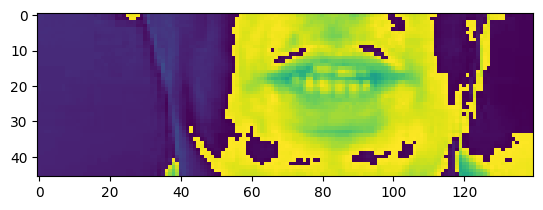

In [17]:
plt.imshow(frames[40])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [21]:
from matplotlib import pyplot as plt

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
sample = data.as_numpy_iterator()

In [25]:
val = sample.next(); val[0]

array([[[[[ 1.4848511 ],
          [ 1.6052444 ],
          [ 1.5249822 ],
          ...,
          [ 0.28091776],
          [ 0.28091776],
          [ 0.20065555]],

         [[ 1.5249822 ],
          [ 1.6052444 ],
          [ 1.44472   ],
          ...,
          [ 0.28091776],
          [ 0.28091776],
          [ 0.20065555]],

         [[ 1.3644577 ],
          [ 1.3644577 ],
          [ 1.44472   ],
          ...,
          [ 0.28091776],
          [ 0.16052444],
          [ 0.16052444]],

         ...,

         [[ 1.0434089 ],
          [ 1.0434089 ],
          [ 1.0434089 ],
          ...,
          [10.233433  ],
          [10.233433  ],
          [10.233433  ]],

         [[ 1.0032778 ],
          [ 1.0032778 ],
          [ 0.9631467 ],
          ...,
          [10.193302  ],
          [10.193302  ],
          [10.193302  ]],

         [[ 0.9631467 ],
          [ 0.9631467 ],
          [ 0.9631467 ],
          ...,
          [10.193302  ],
          [10.193302  ],
          

In [26]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

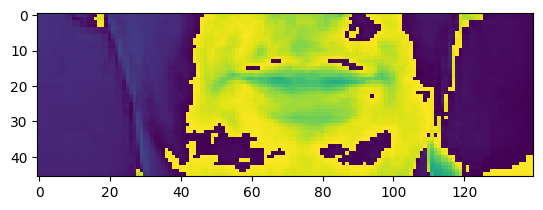

In [27]:
plt.imshow(val[0][0][35])


In [28]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in a five again'>

3. Design the Deep Neural Network *italicised text*

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [30]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [31]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [33]:
yhat = model.predict(val[0])

1/1 [==============================] - 16s 16s/step


In [34]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])



<tf.Tensor: shape=(), dtype=string, numpy=b'hnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'>

In [35]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'hnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'>

In [36]:
model.input_shape


(None, 75, 46, 140, 1)

In [37]:
model.output_shape

(None, 75, 41)

4. Setup Training Options and Train

In [38]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [39]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [40]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [42]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [43]:
schedule_callback = LearningRateScheduler(scheduler)


In [44]:
example_callback = ProduceExample(test)


In [45]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])



5. Make a Prediction

In [46]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')


Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y 



['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [47]:
model.load_weights('models/checkpoint')

In [48]:
test_data = test.as_numpy_iterator()

In [49]:
 # sample = test_data.next()

In [50]:
 # yhat = model.predict(sample[0])

In [51]:
# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [52]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [53]:
# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]



```
`# This is formatted as code`
```

Test on a Video

In [54]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg')) #./data/s1/bras9a.mpg

In [55]:
print('~'*100, 'REAL TEXT')
#[tf.strings.reduce_join([num_to_char(tf.cast(word, tf.int32)) for word in sentence]) for sentence in [sample[1]]]
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [56]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 6s 6s/step


In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [58]:
decoded_sentences = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Convert tensors to strings
decoded_sentences = [sentence.numpy().decode('utf-8') for sentence in decoded_sentences]

# Print the separator and label
print('~' * 100, 'PREDICTIONS')

# Print the decoded sentences
for sentence in decoded_sentences:
    print(sentence)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
bin red at s nine again


In [59]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/Mycheckpoint2.h5")